In [1]:
#@title Imports { display-mode: "form" }

import matplotlib.pyplot as plt
import numpy as np
import time

import pandas as pd
import seaborn as sns

import tensorflow as tf

# tff for Tensorflow Finance
import tf_quant_finance as tff 

# Shortcut alias
pde = tff.math.pde

from IPython.core.pylabtools import figsize
figsize(21, 14)  # better graph size for Colab  

import warnings
warnings.filterwarnings("ignore",
                        category=FutureWarning)  # suppress printing warnings


In [34]:
#@title American Option pricer

# tf.function decorator makes the function faster in graph mode.
# Autograph is disabled in order to depracate the warnings
@tf.function(autograph=False)
def american_option(number_grid_points,
                    time_delta,
                    strike,
                    volatility,
                    risk_free_rate,
                    expiry,
                    dtype=tf.float64):
  """ Computes American Call options prices.

  Args:
    number_grid_points: A Python int. Number of grid points for the finite
      difference scheme.
    time_delta: A Python float. Grid time discretization parameter.
    strike: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the strikes of the underlying American options. 
    volatility: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the volatilities of the underlying American options. 
    risk_free_rate: A real `Tensor` of shape `(number_of_options, 1)`.
      Represents the risk-free interest rates associated with the underlying
      American options.
    expiry: A Python float. Expiry date of the options. If the options
      have different expiries, volatility term has to adjusted to
      make expiries the same.
    dtype: Optional `tf.dtype` used to assert dtype of the input `Tensor`s.

  Returns:
    A tuple of the estimated option prices of shape
    `(number_of_options, number_grid_points)` and the corresponding `Tensor` 
    of grid locations of shape `(number_grid_points,)`.
  """
  # Define the coordinate grid
  s_min = 0.01
  s_max = 500.
  grid = pde.grids.uniform_grid(minimums=[s_min],
                                maximums=[s_max],
                                sizes=[number_grid_points],
                                dtype=dtype)

  # Define the values grid for the final condition
  s = grid[0]
  final_values_grid = tf.nn.relu(s - strike)

  # Define the PDE coefficient functions
  def second_order_coeff_fn(t, grid):
    del t
    s = grid[0]
    return [[volatility ** 2 * s ** 2 / 2]]

  def first_order_coeff_fn(t, grid):
    del t
    s = grid[0]
    return [risk_free_rate * s]

  def zeroth_order_coeff_fn(t, grid):
    del t, grid
    return -risk_free_rate

  # Define the boundary conditions
  @pde.boundary_conditions.dirichlet
  def lower_boundary_fn(t, grid):
    del t, grid
    return tf.constant(0.0, dtype=dtype)

  @pde.boundary_conditions.dirichlet
  def upper_boundary_fn(t, grid):
    del grid
    return tf.squeeze(s_max - strike * tf.exp(-risk_free_rate * (expiry - t)))

  # In order to price American option one needs to set option values to 
  # V(x) := max(V(x), max(x - strike, 0)) after each iteration
  def values_transform_fn(t, grid, values):
    del t
    s = grid[0]
    values_floor = tf.nn.relu(s - strike)
    return grid, tf.maximum(values, values_floor)

  # Solve
  estimate_values, estimate_grid, _, _ = \
    pde.fd_solvers.solve_backward(
      start_time=expiry,
      end_time=0,
      values_transform_fn=values_transform_fn,
      coord_grid=grid,
      values_grid=final_values_grid,
      time_step=time_delta,
      boundary_conditions=[(lower_boundary_fn, upper_boundary_fn)],
      second_order_coeff_fn=second_order_coeff_fn,
      first_order_coeff_fn=first_order_coeff_fn,
      zeroth_order_coeff_fn=zeroth_order_coeff_fn,
      dtype=dtype
    )
  return estimate_values, estimate_grid[0]



def option_param(number_of_options, dtype, seed=42):
  """ Function to generate volatilities, rates, strikes """
  np.random.seed(seed)
  if number_of_options > 1:
    volatility = tf.random.uniform(shape=(number_of_options, 1),
                                   dtype=dtype) * 0.1 + 0.3
    # Random risk free rate between 0 and 0.2.
    risk_free_rate = tf.constant(
      np.random.rand(number_of_options, 1) * 0.05, dtype)
    # Random strike between 20 and 120.
    strike = tf.constant(
      np.random.rand(number_of_options, 1) * 100 + 50, dtype)
  else:
    volatility = tf.constant([0.3], dtype)
    risk_free_rate = tf.constant([0.05], dtype)
    strike = tf.constant([50], dtype)
  return volatility, risk_free_rate, strike

In [35]:
#@title Price multiple American Call options at a time

number_of_options = 10 #@param

time_delta = 0.005

expiry = 1.0  

number_grid_points = 2024 

dtype = tf.float64 

spot = 110  + tf.random.uniform(shape=[number_of_options, 1], dtype=dtype)

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

# Build a graph to compute prices of the American Options.
estimate, grid_locations = american_option(
    time_delta=time_delta,
    expiry=expiry,
    number_grid_points=number_grid_points,
    volatility=volatility,
    risk_free_rate=risk_free_rate,
    strike=strike,
    dtype=dtype)

# Convert to numpy for plotting
estimate = estimate.numpy()
grid_locations = grid_locations.numpy()

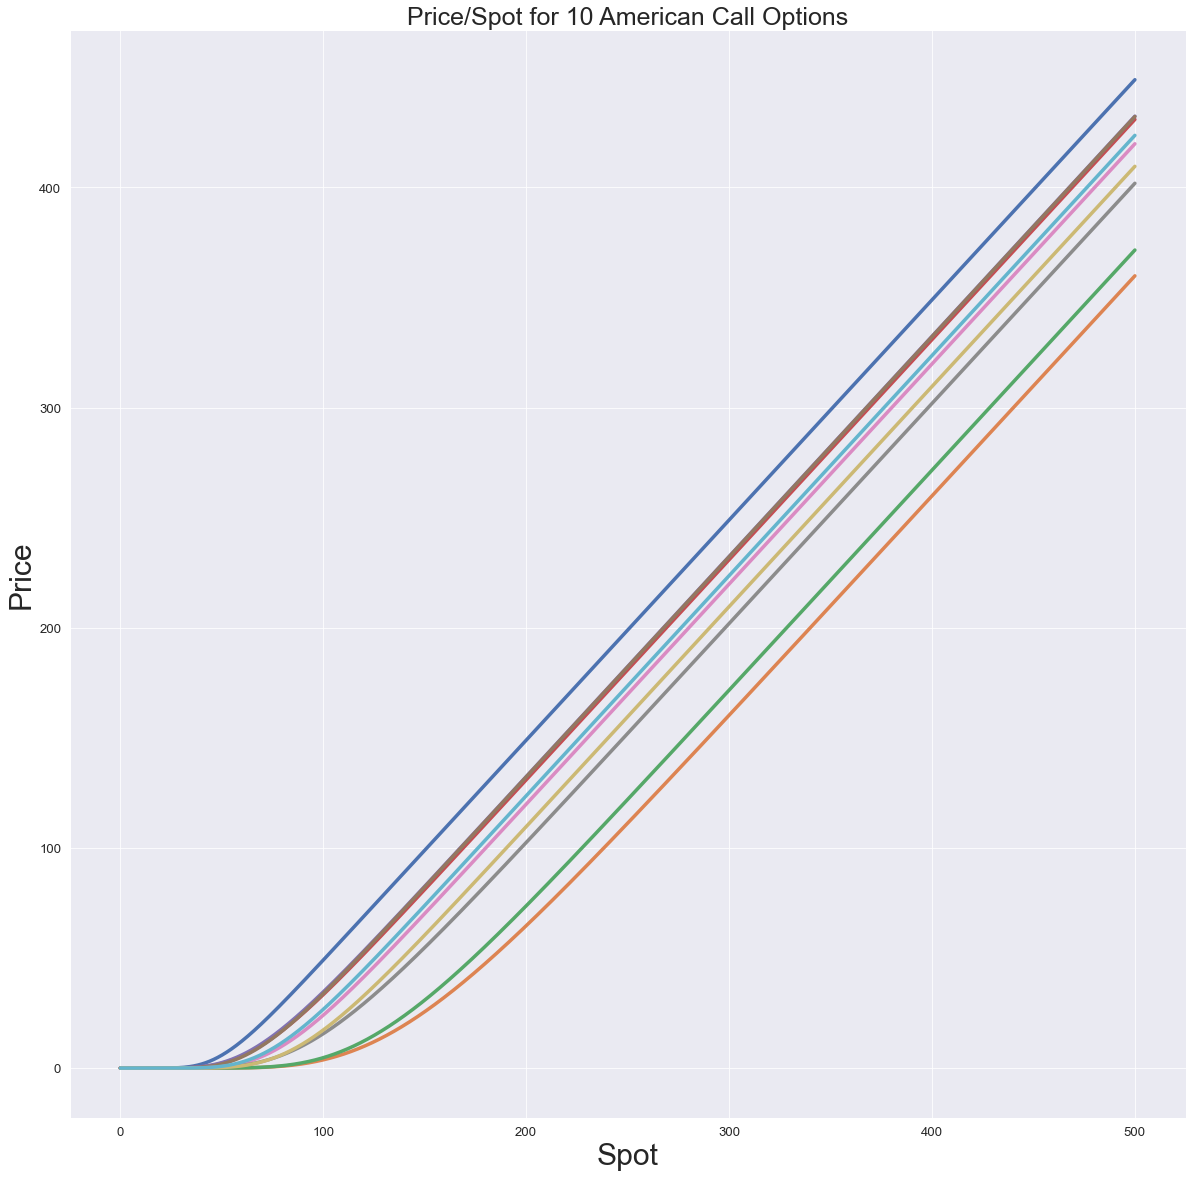

In [36]:
#@title Price/spot plot for the American Call options
# Prepare data for plotting 
options = [x + 1 for x in range(number_of_options) for _ in range(2024)]
plot_data = pd.DataFrame({
    'Spot': list(np.ndarray.flatten(grid_locations)) * number_of_options, 
    'Price': estimate.flatten(),
    'Option': options})


# Plot
plt.figure(figsize=(20, 20))
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 3.5})
plot = sns.lineplot(x="Spot", y="Price", hue="Option",
                    data=plot_data,
                    palette=sns.color_palette()[:number_of_options],
                    legend=False)
plot.axes.set_title(f"Price/Spot for {number_of_options} American Call Options",
                    fontsize=25)
xlabel = plot.axes.get_xlabel()
ylabel = plot.axes.get_ylabel()
plot.axes.set_xlabel(xlabel, fontsize=30)
plot.axes.set_ylabel(ylabel, fontsize=30)
plt.show()

In [37]:
#@title Tensorflow Finance pricing on GPU

number_of_options = 5000  #@param

time_delta = 0.005

expiry = 1.0 

number_grid_points = 1024

dtype = tf.float64

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

device = "/gpu:0"
with tf.device(device):
  
  # Warmup
  estimate, _ = american_option(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)

  # Timed run
  t = time.time()
  estimate, _ = american_option(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)
  time_gpu = time.time() - t
    
gpu_options_per_second = number_of_options / time_gpu
print('------------------------')
print('Tensorflow GPU')
print('wall time: ', time_gpu)
print('options per second: ', gpu_options_per_second)
print('------------------------')

------------------------
Tensorflow GPU
wall time:  49.97070074081421
options per second:  100.0586328763684
------------------------


In [38]:
#@title Tensorflow Finance pricing on CPU

number_of_options = 500  #@param

time_delta = 0.005

expiry = 1.0 

number_grid_points = 1024

dtype = tf.float64

# Generate volatilities, rates, strikes
volatility, risk_free_rate, strike = option_param(number_of_options, dtype)

device = "/cpu:0"
with tf.device(device):
  
  # Warmup
  estimate, _ = american_option(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)

  # Timed run
  t = time.time()
  estimate, _ = american_option(
      time_delta=time_delta,
      expiry=expiry,
      number_grid_points=number_grid_points, 
      volatility=volatility,
      risk_free_rate=risk_free_rate,
      strike=strike,
      dtype=dtype)
  time_cpu = time.time() - t

cpu_options_per_second = number_of_options / time_cpu
print('Tensorflow CPU')
print('wall time: ', time_cpu)
print('options per second: ', cpu_options_per_second)
print('------------------------')

Tensorflow CPU
wall time:  5.156219959259033
options per second:  96.97026192650085
------------------------


In [39]:
#@title Quantlib  pricing

# Will run only if QuantLib is installed

number_of_options = 5000  #@param

time_delta = 0.005

expiry = 1.0 

number_grid_points = 1024

import QuantLib as ql
warnings.filterwarnings("ignore",
                        category=UserWarning,
                        module="QuantLib")
calculation_date = ql.Date(1, 1, 2010)
maturity_date = ql.Date(1, 1, 2011)
day_count = ql.Thirty360()
calendar = ql.NullCalendar()

ql_strike_price = 50
ql_volatility = 0.3
ql_risk_free_rate = 0.05
option_type = ql.Option.Call

ql.Settings.instance().evaluationDate = calculation_date
payoff = ql.PlainVanillaPayoff(option_type, ql_strike_price)

am_exercise = ql.AmericanExercise(calculation_date, maturity_date)
american_option_ql = ql.VanillaOption(payoff, am_exercise)

flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, ql_risk_free_rate, day_count)
)

flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar, ql_volatility, day_count)
)

spot_price = 4
spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)
bsm_process = ql.BlackScholesProcess(spot_handle,
                                      flat_ts,
                                      flat_vol_ts)
# Compute the same price number_of_options times for fair time comparison
t = time.time()
for i in range(number_of_options):  
  fd_american_engine = ql.FDAmericanEngine(bsm_process,
                                           timeSteps=int(expiry / time_delta),
                                           gridPoints=number_grid_points)
  american_option_ql.setPricingEngine(fd_american_engine)
  price = american_option_ql.NPV()
time_ql = time.time() - t

ql_options_per_second = number_of_options / time_ql
print('------------------------')
print('QuantLib')
print('wall time: ', time_ql)
print('options per second: ', ql_options_per_second)
print('------------------------')

------------------------
QuantLib
wall time:  31.17835760116577
options per second:  160.36765194498403
------------------------


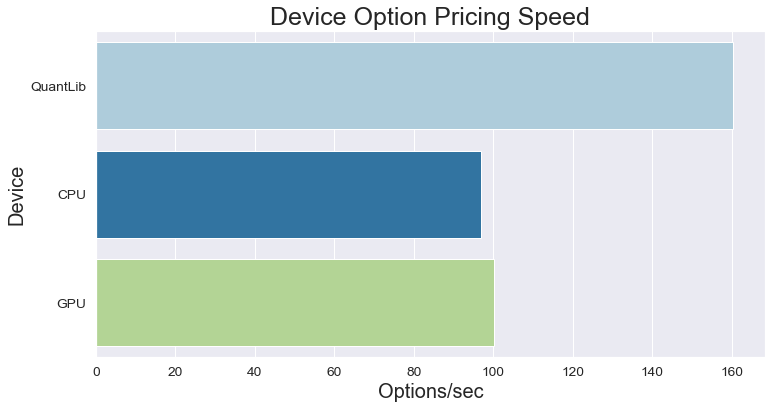

In [40]:
#@title Tensorflow Finance vs QuantLib
# Throughput
times_pd = pd.DataFrame([('QuantLib', ql_options_per_second), 
                         ('CPU', cpu_options_per_second), 
                         ('GPU', gpu_options_per_second)],
                         columns=['Device', 'Options/sec'])
sns.set(style="darkgrid", palette="Paired")
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 6))
pt = sns.barplot(y="Device", x="Options/sec", data=times_pd)
pt.axes.set_title("Device Option Pricing Speed", fontsize=25)
xlabel = pt.axes.get_xlabel()
ylabel = pt.axes.get_ylabel()
pt.axes.set_xlabel(xlabel, fontsize=20)
pt.axes.set_ylabel(ylabel, fontsize=20)
plt.show()

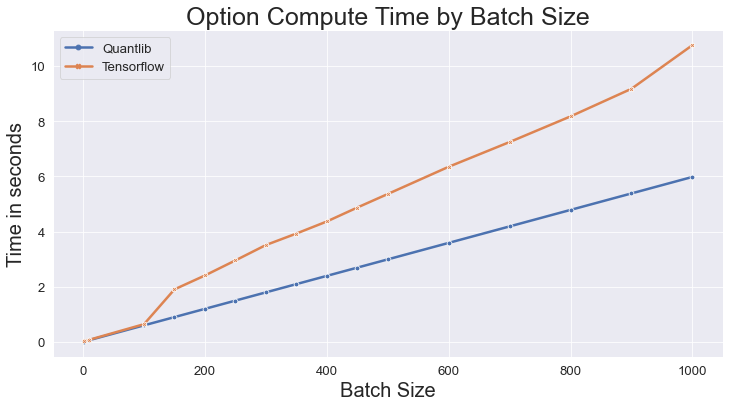

In [41]:
#@title Time to price a batch of options (GPU vs QuantLib)

import matplotlib.pyplot as plt
import numpy as np
import time
batch_of_options = [1, 10, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]  #@param

gpu_times = []
cpu_times = []


for options in batch_of_options:
    
  # Generate volatilities, rates, strikes
  volatility, risk_free_rate, strike = option_param(options, dtype)

  with tf.device("/gpu:0"):
    
    # Warmup
    estimate, _ = american_option(
        time_delta=time_delta,
        expiry=expiry,
        number_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)
    
    # Timed run
    t = time.time()
    estimate, _ = american_option(
        time_delta=time_delta,
        expiry=expiry,
        number_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)
    time_gpu = time.time() - t
    
  gpu_times.append(time_gpu)

# We hardcode QunatLib values here for simplicity
ql_times = [29.9 / 5000 * i for i in batch_of_options]

# Prepare Plotting 
plt.figure(figsize=(12, 6))
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
batches = batch_of_options * 2
num_batches = len(batch_of_options)
method = ["Quantlib"] * num_batches +  ["Tensorflow"] * num_batches
times = ql_times + gpu_times
data = {"Batch Size": batches,
        "Method": method,
        "Times": times}
ql_gpu_times = pd.DataFrame(data = data)
plot = sns.lineplot(x="Batch Size", y="Times", hue="Method", style = "Method",
                    data=ql_gpu_times, markers=True, dashes=False, color=('darkorange',
                                                                          'royalblue'))
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[1:], labels=labels[1:], loc="upper left")
plot.axes.set_title("Option Compute Time by Batch Size",fontsize=25)
xlabel = plot.axes.get_xlabel()
plot.axes.set_xlabel(xlabel, fontsize=20)
plot.axes.set_ylabel('Time in seconds', fontsize=20)
plt.setp(plot.get_legend().get_title(), fontsize=28)
plt.show()

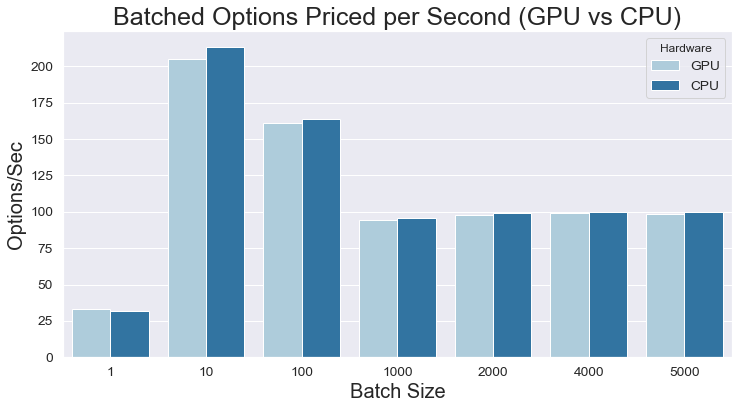

In [43]:
#@title Options per second depending on the batch size

batch_of_options = [1, 10, 100, 1000, 2000, 4000, 5000]  #@param
gpu_times = []
cpu_times = []

for options in batch_of_options:
    
  with tf.device("/gpu:0"):
        
    # Generate volatilities, rates, strikes
    volatility, risk_free_rate, strike = option_param(options, dtype)
    
    # Warmup
    estimate = american_option(
        time_delta=time_delta,
        expiry=expiry,
        number_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)
    
    # Timed run
    t = time.time()
    estimate = american_option(
        time_delta=time_delta,
        expiry=expiry,
        number_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)
    time_gpu = time.time() - t

  gpu_times.append(options / time_gpu)

for options in batch_of_options:

  with tf.device("/cpu:0"):
        
    # Generate volatilities, rates, strikes
    volatility, risk_free_rate, strike = option_param(options, dtype)
    
    # Warmup
    estimate = american_option(
        time_delta=time_delta,
        expiry=expiry,
        number_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)
    
    # Timed run
    t = time.time()
    estimate = american_option(
        time_delta=time_delta,
        expiry=expiry,
        number_grid_points=number_grid_points,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        strike=strike,
        dtype=dtype)
    time_cpu = time.time() - t
    
  cpu_times.append(options / time_cpu)

# Prepare data for plotting
plt.figure(figsize=(12, 6))
batches = batch_of_options * 2
num_batches = len(batch_of_options)
method = ["GPU"] * num_batches +  ["CPU"] * num_batches
times = gpu_times + cpu_times
data = {"Batch Size": batches,
        "Hardware": method,
        "Options/Sec": times}
gpu_cpu_times = pd.DataFrame(data = data)
sns.set(style="darkgrid", palette="Paired")
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
pt = sns.barplot(x="Batch Size", y="Options/Sec",hue="Hardware", data=gpu_cpu_times)
pt.axes.set_title("Batched Options Priced per Second (GPU vs CPU)",fontsize=25)
xlabel = pt.axes.get_xlabel()
ylabel = pt.axes.get_ylabel()
pt.axes.set_xlabel(xlabel, fontsize=20)
pt.axes.set_ylabel(ylabel, fontsize=20)
plt.show()